# Business Understanding: Airbnb Analysis

In this notebook, you will find my solution to four relevant business questions inspired by the Airbnb Datasets of Seattle and Boston:

* Are Superhosts more successful, i.e. can they charge more? Are they better reviewed in comparison to regular hosts?
* In which neighbourhood do we find the most expensive listings, on average? Does that correlate to the neighbourhood's attractions? Is there a relationship between rent prices and Airbnb prices?
* How do price and availability fluctuate over the year?
* How do property characteristics influence price? 

I followed the CRISP-DM Framework and the DRY Principles to write this notebook. The first part is exploratory, and the second one uses the data to answer the aforementioned questions.

# 1. Data Understanding 

I will try to understand the data better in the following cells. Irrelevant code was suppressed in sake of concision. The source of the dataset offers powerful insights into the meaning of each feature: http://insideairbnb.com/about.html#disclaimers 

In [1]:
#Importing relevant libraries and modules
import datetime
import json
import math
import mplleaflet
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import requests
import seaborn as sns
import statistics

from collections import defaultdict
from datetime import date, timedelta, datetime
from matplotlib.ticker import PercentFormatter
from pandas.plotting import register_matplotlib_converters
from scipy import stats
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

register_matplotlib_converters()
%matplotlib inline

In [127]:
# Seattle Datasets
listing_df = pd.read_csv('./listings_seattle.csv')
calendar_df = pd.read_csv('./calendar_seattle.csv')

In [128]:
# Boston Datasets 
listing_df_b = pd.read_csv('./listings_boston.csv')
calendar_df_b = pd.read_csv('./calendar_boston.csv')

### 1.1. Looking into the Listings Files

The "listings" dataset includes many interesting data points for Seattle and Boston. It is a snapshot of all available listings in January/2016 and September/2016 for Seattle and Boston, respectively. 

In [96]:
# Sneak Peek at the Seattle data 
listing_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [97]:
# Sneak Peek at the Boston data 
listing_df_b.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [84]:
# Number of Listings 
print('In Seattle there are {} listed properties'.
     format(listing_df.shape[0]))
print('In Boston there are {} listed properties'.
     format(listing_df_b.shape[0]))

In Seattle there are 3818 listed properties
In Boston there are 3585 listed properties


In [85]:
# Number of parameters
print('The Seattle Listing dataset has {} features'.
     format(listing_df.shape[1]))
print('The Boston Listing dataset has {} features'.
     format(listing_df_b.shape[1]))

The Seattle Listing dataset has 92 features
The Boston Listing dataset has 95 features


In [86]:
# Looking into the Seattle features
listing_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [91]:
# Identifying features there are exclusively in the Boston Dataset
[x for x in listing_df_b.columns if x not in listing_df.columns]

['access', 'interaction', 'house_rules']

In [95]:
# Identifying categorical data
# Curiously, 'price' parameters appear here!
# We will most definetely need to clean the data...
listing_df_b.select_dtypes(include=['object']).columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',
       'zipcode', 'market', 'smart_location', 'country_code', 'country',
       'is_location_exact', 'property_type', 'room_type', 'bed_type',
       'amenities', 'price', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'extra_people', 'calendar_updated',
       'calendar_last_scraped', 'first_rev

In [218]:
# Looking into the available information, 
# I have created groups of features to support the analysis

# General Information
gen_cols = ['id', 'name']

# Text Description
text_cols = ['summary', 'space', 'description', 'neighborhood_overview', 
             'notes', 'transit','access', 'interaction', 'house_rules']

# Host Info
host_cols = ['host_id', 'host_url', 'host_name', 'host_since',
            'host_location', 'host_about', 'host_response_time',
            'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
            'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
            'host_listings_count', 'host_total_listings_count',
            'host_verifications', 'host_has_profile_pic', 
            'host_identity_verified', 'calculated_host_listings_count']

# Location Info
loc_cols = ['street', 'neighbourhood', 'neighbourhood_cleansed',
           'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 
           'smart_location', 'latitude', 'longitude',
           'is_location_exact']

# Apartment Info
apt_cols = ['property_type', 'room_type', 'accommodates',
           'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet']

# Price Info
price_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit',
            'cleaning_fee', 'guests_included', 'extra_people']

# Availability
aval_cols = ['minimum_nights', 'maximum_nights', 'calendar_updated', 
           'availability_30', 'availability_60', 'availability_90',
           'availability_365']

# Reviews - Satisfaction
rev_cols = ['number_of_reviews', 'review_scores_rating',
           'review_scores_accuracy', 'review_scores_cleanliness',
           'review_scores_checkin', 'review_scores_communication',
           'review_scores_location', 'review_scores_value', 'reviews_per_month']

# Booking
book_cols = ['instant_bookable', 'cancellation_policy', 'require_guest_profile_picture',
           'require_guest_phone_verification']

### 1.2. Looking into the Calendar Files

The calendar files seem to show price and availability over time, for each active listing on Airbnb. Let's check it out. 

In [99]:
# Sneak Peek at the data from Seattle
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [100]:
# Sneak Peek at the data from Boston
calendar_df_b.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [98]:
# Number of Rows 
print('There are {} entries in the calendar file for Seattle'.
     format(calendar_df.shape[0]))
print('There are {} entries in the calendar file for Boston'.
     format(calendar_df_b.shape[0]))

There are 1393570 entries in the calendar file for Seattle
There are 1308890 entries in the calendar file for Boston


In [107]:
# These numbers are huge! 
# There is approximately one year of data for each listing
print('There are app. {} entries per Listing in the calendar file for Seattle'.
     format(round(calendar_df.shape[0]/listing_df.shape[0])))
print('There are app. {} entries per Listing in the calendar file for Boston'.
     format(round(calendar_df_b.shape[0]/listing_df_b.shape[0])))

There are app. 365 entries per Listing in the calendar file for Seattle
There are app. 365 entries per Listing in the calendar file for Boston


In [112]:
# Let's check the data types
# We will have to change those later
print('Dates are saved as {}.'.format(type(calendar_df['date'][0])))
print('Price is saved as {}.'.format(type(calendar_df['price'][0])))

Dates are saved as <class 'str'>.
Price is saved as <class 'str'>.


### 1.3. Visualizing the data

Helps visualizing and understanding the information. To understand which percentage of values falls into a certain category, I used bar plots and the relative frequency of each data point.

In [10]:
def get_prop(df, col):
    '''
    INPUT:
    df - the pandas dataframe whose column has to be plotted
    col - the column name to be plotted
    
    OUTPUT:
    prop_df - pandas series with each unique value found on df[col]
              and its respective proportion
    '''
    
    prop_df = df[col].value_counts().sort_values()/(df.shape[0]-sum(df[col].isnull()))
    return prop_df

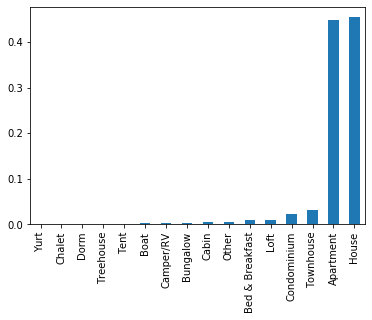

In [11]:
# Property_type distribution
get_prop(listing_df, 'property_type').plot(kind='bar');

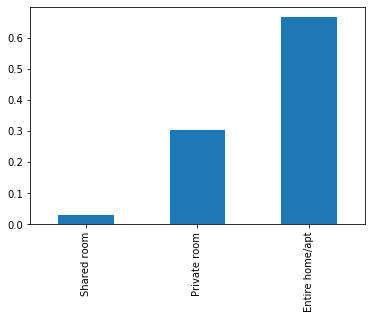

In [12]:
# Room_type distribution
get_prop(listing_df, 'room_type').plot(kind='bar');

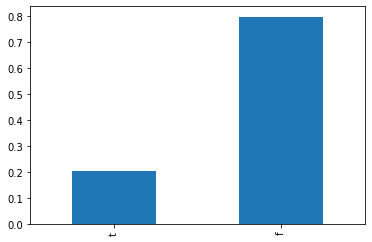

In [13]:
# Superhosts distribution
get_prop(listing_df, 'host_is_superhost').plot(kind='bar');

# 2. Data Preparation

The previous steps revealed to us how the data should be prepared. For instance, some numerical columns are saved as strings. We will also evaluate columns with one single value and multiple NaN values. 

### 2.1. Cleaning the Listings Files

In [137]:
def single_value_drop(df):
    '''
    INPUT:
    df - the pandas dataframe whose columns ought to be checked
    
    OUTPUT:
    clean_df - pandas dataframe without single-value columns
    '''
    
    clean_df = df
    
    for col in df.columns:
        if len(df[col].unique()) == 1:
            clean_df = clean_df.drop(col, axis = 1)
            print('The following column was deleted: {}'. format(col))
            
    return clean_df

In [139]:
# Apply in Seattle Dataset
listing_df = single_value_drop(listing_df)

# Apply in Boston Dataset
listing_df_b = single_value_drop(listing_df_b)

In [152]:
# Seattle: Checking for columns with > 25% missing values
listing_df.isnull().mean()[listing_df.isnull().mean()>0.25].sort_values(ascending=False)*100

square_feet              97.459403
monthly_price            60.267156
security_deposit         51.126244
weekly_price             47.380828
notes                    42.063908
neighborhood_overview    27.029859
cleaning_fee             26.977475
dtype: float64

In [153]:
# Boston: Checking for columns with > 25% missing values
listing_df_b.isnull().mean()[listing_df_b.isnull().mean()>0.25].sort_values(ascending=False)*100

square_feet              98.437936
monthly_price            75.230126
weekly_price             75.118550
security_deposit         62.566248
notes                    55.090656
interaction              43.347280
access                   41.534170
neighborhood_overview    39.470014
host_about               36.513250
transit                  35.983264
house_rules              33.249651
cleaning_fee             30.878661
space                    29.483961
dtype: float64

In [154]:
# In both datasets, square_feet data is 
# virtually not present. We are dropping these cols

listing_df = listing_df.drop(columns=['square_feet'])
listing_df_b = listing_df_b.drop(columns=['square_feet'])

In [155]:
# Function to clean and convert numbers saved as strings
def clean_price(x):
    '''
    INPUT:
    x - string to be cleaned '$*,*'
    
    OUTPUT:
    x - if x is already cleaned and saved as a float
    x_clean - x cleaned and saved as float
    '''
    try:
        x_clean =float(x.replace('$', '').replace(',', ''))
        return x_clean
    except:
        return x

In [158]:
# Applying to Seattle Dataset
for col in price_cols:
    listing_df[col] = listing_df[col].apply(lambda x: clean_price(x))
    
# Applying to Boston Dataset
for col in price_cols:
    listing_df_b[col] = listing_df_b[col].apply(lambda x: clean_price(x))

In [170]:
# Checking if there are any missing values in 'price'
# As expected, there isn't any - everyone wants to be paid!
print('Seattle: {} missing prices'.format(listing_df['price'].isnull().mean()))
print('Boston: {} missing prices'.format(listing_df_b['price'].isnull().mean()))

Seattle: 0.0 missing prices
Boston: 0.0 missing prices


In [162]:
# Function to clean percentage values saved as strings
def clean_perc(x):
    '''
    INPUT:
    x - string to be cleaned '*%'
    
    OUTPUT:
    x - if x is already cleaned and saved as a float
    x_clean - x cleaned and saved as float
    '''
    try:
        return float(x.replace('%', ''))/100
    except:
        return x

In [163]:
# Applying to Seattle Dataset
listing_df['host_response_rate'] = listing_df['host_response_rate'].apply(lambda x: clean_perc(x))

# Applying to Seattle Dataset
listing_df_b['host_response_rate'] = listing_df_b['host_response_rate'].apply(lambda x: clean_perc(x))

### 2.2. Cleaning the Calendar Files

In [166]:
# Converting 'price' from string to float
calendar_df['price'] = calendar_df['price'].apply(lambda x: clean_price(x))
calendar_df_b['price'] = calendar_df_b['price'].apply(lambda x: clean_price(x))

# Converting 'available' from string to int (1 if t, 0 if f)
calendar_df['available'] = pd.get_dummies(calendar_df['available'], drop_first=True)
calendar_df_b['available'] = pd.get_dummies(calendar_df_b['available'], drop_first=True)

# Converting 'date' from string to date
calendar_df['date'] = (calendar_df['date'].apply(datetime.strptime, args=('%Y-%m-%d',)))
calendar_df_b['date'] = (calendar_df_b['date'].apply(datetime.strptime, args=('%Y-%m-%d',)))

# 3. Research Questions

## 1. Are Superhosts more sucessful? 

As an AirBnB client, I have asked myself: what characterizes a "Superhost"? For me, the category was a synonym of better quality, as a "stamp of approval" from AirBnB itself, but also of higher prices.

Based on the Seattle AirBnB data, I would like to know - are "Superhosts" actually better reviewed? And does the "Superhost" Badge mean higher prices? Let's find out!

### 1.1. Price: are Superhosts in Seattle able to charge more?

#### 1.1.1. Descriptive Statistics and t-tests

In this first section, I will calculate descriptive statistics for both the Superhost and the Regular (non-Superhost) groups. Then I will perform t-tests to compare these samples and reach conclusions about the data. I have created three metrics of price, to analyze it from different perspectives:
   
   * Price per night ('price')
   * Price per night + Cleaning fee ('total_price')
   * Price per night + Clening fee + Security deposit ('sec_price')

Even though I'd love to stretch my findings for all US Airbnb listings, Seattle cannot be considered a random sample of listings. Refer to this paper for more information: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3105563/

In [222]:
# Total price column:
# price/night + cleaning fee (if any)
listing_df['total_price'] = (listing_df['price']
                            + listing_df['cleaning_fee'].fillna(0))

# Hosts can also charge security deposits
# Those are a guarantee in case the property is damaged
# The guest accepts to pay it in case of damage
listing_df['sec_price'] = (listing_df['total_price']
                          + listing_df['security_deposit'].fillna(0))

In [323]:
# Dataframe for superhosts:
super_df = listing_df[listing_df['host_is_superhost'] == 't']
print('There are {} Superhosts in Seattle'.format(super_df.shape[0]))

# Dataframe for regular hosts:
reg_df = listing_df[listing_df['host_is_superhost'] == 'f']
print('There are {} Regular hosts in Seattle'.format(reg_df.shape[0]))

# Proportion of Superhosts
print('{:.1f}% are Superhosts'.format(super_df.shape[0]*100/listing_df.shape[0]))

There are 778 Superhosts in Seattle
There are 3038 Regular hosts in Seattle
20.4% are Superhosts


In [209]:
# Max and Min Values for price

# Superhost:
print('Superhosts price/night: Min. USD {:.2f}, Max. USD {:.2f}'.
      format(min(super_df['price']), max(super_df['price'])))

# Regular host:
print('Regular hosts price/night: Min. USD {:.2f}, Max. USD {:.2f}'.
      format(min(reg_df['price']), max(reg_df['price'])))

Superhosts price/night: Min. USD 30.00, Max. USD 750.00
Regular hosts price/night: Min. USD 20.00, Max. USD 1000.00


In [210]:
# Max and Min Values for price + cleaning fee

# Superhost:
print('Superhosts price + cleaning fee: Min. USD {:.2f}, Max. USD {:.2f}'.
      format(min(super_df['total_price']), max(super_df['total_price'])))

# Regular host:
print('Regular hosts price + cleaning fee: Min. USD {:.2f}, Max. USD {:.2f}'.
      format(min(reg_df['total_price']), max(reg_df['total_price'])))

Superhosts price + cleaning fee: Min. USD 38.00, Max. USD 1050.00
Regular hosts price + cleaning fee: Min. USD 20.00, Max. USD 1275.00


In [212]:
# Max and Min Values for price + cleaning fee + security deposit

# Superhost:
print('Superhosts price + cleaning fee + security deposit: Min. USD {:.2f}, Max. USD {:.2f}'.
      format(min(super_df['sec_price']), max(super_df['sec_price'])))

# Regular host:
print('Regular hosts price + cleaning fee + security deposit: Min. USD {:.2f}, Max. USD {:.2f}'.
      format(min(reg_df['sec_price']), max(reg_df['sec_price'])))

Superhosts price + cleaning fee + security deposit: Min. USD 38.00, Max. USD 2050.00
Regular hosts price + cleaning fee + security deposit: Min. USD 20.00, Max. USD 5350.00


In [223]:
# Relevant Price Columns in Listings_df:
price_cols = price_cols + ['total_price', 'sec_price']

# Superhost Average Price Parameters:
super_pri_mean = pd.DataFrame(super_df[price_cols].mean())

# Regular host Average Price Parameters:
reg_pri_mean = pd.DataFrame(reg_df[price_cols].mean())

In [214]:
# Creating function to compare two samples in a t-test
def two_tail_t_test(reg_df, super_df, col, alpha):
    
    '''
    INPUT:
    reg_df - the first pandas dataframe to compare in a t-test
    super_df - the second pandas dataframe to compare in a t-test
    col - the column name to be compared
    size - how big should the bins in your histogram be
    
    OUTPUT:
    Displays a double-histogram plot and the 25%, 50% and 75% percentiles 
    '''

    # T-test: Comparing Superhosts and regular hosts

    # Calculating regular host parameters
    sample_r = reg_df.shape[0]
    mean_sample_r = reg_df[col].mean()
    stdev_sample_r = statistics.stdev(reg_df[col])
    sum_squares_r = reg_df[col].var(ddof=1)*(sample_r-1)

    # Calculating superhost parameters
    sample_s = super_df.shape[0]
    mean_sample_s = super_df[col].mean()
    stdev_sample_s = statistics.stdev(super_df[col])
    sum_squares_s = super_df[col].var(ddof=1)*(sample_s-1)

    # Independent samples t-test 
    # Degrees of freedom:
    deg_f = sample_r + sample_s - 2

    # Pooling variances for a more precise result
    pool_var = (sum_squares_r + sum_squares_s)/deg_f

    # Corrected Standard Error
    st_error = np.sqrt((pool_var/sample_r) + (pool_var/sample_s))

    # Calculating t-statistics
    t = (mean_sample_s - mean_sample_r)/st_error

    # For the alpha value we find our t-critical value (two-tailed)
    t_crit = -stats.t.ppf(alpha/2, deg_f)

    return t, t_crit

In [25]:
# Two-tailed Hypothesis Test: Security Price Results (price/night + cleaning fee + security deposit)
print('\033[1m' 'Two-tailed Statistical Significance Test (alpha = 0.01):''\033[0m' '\n''\n'
      '\033[1m' 'Null Hypothesis:''\033[0m'
      ' No significant difference between regular hosts average total price + security deposit'
      ' and superhosts average total price +  security deposit'  '\n' '\n'
      '\033[1m' 'Alternative Hypothesis:''\033[0m'
      ' There is a significant difference between regular hosts average total price + security deposit'
      ' and superhosts average total price + security deposit' '\n')

# Running the test with alpha = 0.01
t, t_crit = two_tail_t_test(reg_df, super_df, 'sec_price', 0.01)

# Commenting Results
print('Our t statistic {:.2f} is greater than the t critical value {:.2f}, thus it is in the critical zone.'
      .format(t, t_crit))

print('\n''The result is statistically significant for alpha = 0.01.' '\n''\n'
        '\033[1m''If we consider the security deposit, Seattle Superhosts seem to charge more than regular hosts.')

Two-tailed Statistical Significance Test (alpha = 0.01):

Null Hypothesis: No significant difference between regular hosts average total price + security deposit and superhosts average total price +  security deposit

Alternative Hypothesis: There is a significant difference between regular hosts average total price + security deposit and superhosts average total price + security deposit

Our t statistic 2.78 is greater than the t critical value 2.58, thus it is in the critical zone.

The result is statistically significant for alpha = 0.01.

If we consider the security deposit, Seattle Superhosts seem to charge more than regular hosts.


In [180]:
# Two-tailed Hypothesis Test: Total Price Results (price/night + cleaning fee)
print('\033[1m' 'Two-tailed Statistical Significance Test (alpha = 0.01):''\033[0m' '\n''\n'
      '\033[1m' 'Null Hypothesis:''\033[0m'
      ' No significant difference between regular hosts average price/night and superhosts average price/night'  '\n' '\n'
      '\033[1m' 'Alternative Hypothesis:''\033[0m'
      ' There is a significant difference between regular hosts average price/night and superhosts average price/night' '\n')

# Running the test with alpha = 0.01
t, t_crit = two_tail_t_test(reg_df, super_df, 'total_price', 0.01)

# Commenting Results
print('Our t statistic {:.2f} is between the the t critical values ±{:.2f}, thus it is outside of critical zone.'
      .format(t, t_crit))

print('\n''The result is NOT statistically significant for alpha = 0.01.' '\n''\n'
        '\033[1m''When it comes to price per night + cleaning fee, we do not observe'
        ' significant differences between regular and superhosts.')

Two-tailed Statistical Significance Test (alpha = 0.01):

Null Hypothesis: No significant difference between regular hosts average price/night and superhosts average price/night

Alternative Hypothesis: There is a significant difference between regular hosts average price/night and superhosts average price/night

Our t statistic 0.79 is between the the t critical values ±2.58, thus it is outside of critical zone.

The result is NOT statistically significant for alpha = 0.01.

When it comes to price per night + cleaning fee, we do not observe significant differences between regular and superhosts.


In [181]:
# Two-tailed Hypothesis Test: Price/Night Results
print('\033[1m' 'Two-tailed Statistical Significance Test (alpha = 0.01):''\033[0m' '\n''\n'
      '\033[1m' 'Null Hypothesis:''\033[0m'
      ' No significant difference between regular hosts average price/night and superhosts average price/night'  '\n' '\n'
      '\033[1m' 'Alternative Hypothesis:''\033[0m'
      ' There is a significant difference between regular hosts average price/night and superhosts average price/night' '\n')

# Running the test with alpha = 0.01
t, t_crit = two_tail_t_test(reg_df, super_df, 'price', 0.01)

# Commenting Results
print('Our t statistic {:.2f} is between the the t critical values ±{:.2f}, thus it is outside of critical zone.'
      .format(t, t_crit))

print('\n''The result is NOT statistically significant for alpha = 0.01.' '\n''\n'
        '\033[1m''When it comes to price per night, we do not observe significant differences between regular and superhosts.')

Two-tailed Statistical Significance Test (alpha = 0.01):

Null Hypothesis: No significant difference between regular hosts average price/night and superhosts average price/night

Alternative Hypothesis: There is a significant difference between regular hosts average price/night and superhosts average price/night

Our t statistic 0.76 is between the the t critical values ±2.58, thus it is outside of critical zone.

The result is NOT statistically significant for alpha = 0.01.

When it comes to price per night, we do not observe significant differences between regular and superhosts.


#### 1.1.2. Deep Dive: Comparing Price/Night and Total Price

   These intriguing results require further investigation - Superhosts clearly charge more in total, but when we do not consider cleaning fees and security deposits, the difference vanishes. 

In [182]:
# Creating DataFrames with the % of non-missing values in each price column
super_nan = pd.Series(dtype= np.float64)
reg_nan = pd.Series(dtype=np.float64)

for col in price_cols:
    super_nan = super_nan.append(pd.Series([100*(1 - super_df[col].isnull().mean())], index = [col]))
    reg_nan = reg_nan.append(pd.Series([100*(1 - reg_df[col].isnull().mean())], index = [col]))
    
super_nan = pd.DataFrame(super_nan)
reg_nan = pd.DataFrame(reg_nan)

In [224]:
# Analyzing percentage of non-missing values and the means of the three price components:
comp_df = pd.concat([super_pri_mean, super_nan, reg_pri_mean, reg_nan], axis=1, sort=False)
comp_df.columns = ['Superhosts', '% of Listings S', 'Regular Hosts', '% of Listings R']
comp_df['Delta'] = comp_df['Superhosts'] - comp_df['Regular Hosts']

# Conclusions:
print('{:.1f}% of Superhosts charge a security deposit, whereas {:.1f}% of regular hosts do so.'
      .format(super_nan.loc['security_deposit', :][0], reg_nan.loc['security_deposit', :][0]))
print('{:.1f}% of Superhosts charge a cleaning fee, whereas {:.1f}% of regular hosts do so.'
       .format(super_nan.loc['cleaning_fee', :][0], reg_nan.loc['cleaning_fee', :][0]))
print('Significant prices differences are likely due to these extra charges, which are more common ' 
      'among Superhosts.')

# Show Results
comp_df.round(1).style.bar(subset=['Delta'], align='mid', color=['#d65f5f', '#5fba7d'])

58.9% of Superhosts charge a security deposit, whereas 46.3% of regular hosts do so.
79.3% of Superhosts charge a cleaning fee, whereas 71.4% of regular hosts do so.
Significant prices differences are likely due to these extra charges, which are more common among Superhosts.


,Superhosts,% of Listings S,Regular Hosts,% of Listings R,Delta
price,130.100000,100.000000,127.400000,100.000000,2.700000
weekly_price,824.300000,58.900000,777.700000,51.000000,46.700000
monthly_price,2981.000000,47.000000,2495.500000,37.900000,485.500000
security_deposit,280.400000,58.900000,289.900000,46.300000,-9.500000
cleaning_fee,58.100000,79.300000,62.800000,71.400000,-4.700000
guests_included,1.800000,100.000000,1.600000,100.000000,0.200000
extra_people,12.100000,100.000000,10.300000,100.000000,1.800000
total_price,176.200000,100.000000,172.200000,100.000000,4.000000
sec_price,341.300000,100.000000,306.600000,100.000000,34.700000


#### 1.1.3. Visualizing our Data

Plots help Medium readers to visualize our findings and to understand what story our data tells.

In [333]:
def hist_generator(reg_df, super_df, col, size, max_range_99=False, percentil=True, xmin=0):
    
    '''
    INPUT:
    reg_df - the first pandas dataframe whose column you want to plot
    super_df - the second pandas dataframe whose column you want to plot
    col - the column name you want to plot
    size - how big should the bins in your histogram be
    max_range_99 - if true, sets the x-axis maximum value to the 99% quartile.
                   Default is false to show all values.
    percentil - True (default) to plot percentile values and axis
    xmin - minimal x value on the plot. Zero as default.
    
    OUTPUT:
    Displays a double-histogram plot and the 25%, 50% and 75% percentiles 
    '''
    
    # Basis for the analysis
    super_price = super_df[col]
    reg_price = reg_df[col]
        
    if max_range_99 == True:
        # We'll show 99% of the data to exclude outliers
        max_range = int(max(reg_price.quantile(0.99), 
                    super_price.quantile(0.99)))
    else:
        # Max Range is the maximum value of the distributions
        max_range = max(int(super_price.max()) + 1,
                        int(reg_price.max()) + 1)

    # Defining bin size to optimize visualization
    bin_size = list(np.arange(xmin, max_range + 1, size))

    # Defining weights for each distribution
    # that is, the basis for the percentage - samples have different sizes!
    basis_super = np.ones(len(super_price)) / len(super_price)
    basis_reg = np.ones(len(reg_price)) / len(reg_price)

    # Plotting the histogram
    fig = plt.figure(figsize = (15,10))
    plt.hist([reg_price, super_price], weights = [basis_reg, basis_super], alpha=0.5, bins=bin_size)

    # Formatting percentages, legends and axis labels
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1));
    plt.legend(['Regular hosts', 'Superhosts']);
    plt.ylabel('Percentage of listings (%)');
    plt.xlabel(col.capitalize());
    plt.xticks(list(np.arange(xmin, max_range, size)));
    plt.title(col.capitalize() + ': Superhosts vs. Regular hosts' );
    plt.grid(False);

    # Adding 25%, 50% and 75% Percentiles
    if percentil == True:
        reg_quantile = reg_price.quantile([0.25,0.5,0.75])
        super_quantile = super_price.quantile([0.25,0.5,0.75])
        min_ylim, max_ylim = plt.ylim()
        delta = 0.01

        for idx, item in enumerate(reg_quantile):
            plt.axvline(item, color='C0', linestyle='dashed', linewidth=1)
            plt.text(item + 10, max_ylim - delta, '{}. Quartile: {:.2f}'.format(idx + 1, item), color ='C0')
            delta += 0.01

        for idx, item in enumerate(super_quantile):
            plt.axvline(item,  color='darkorange', linestyle='dashed', linewidth=1)
            plt.text(item + 10, max_ylim - delta, '{}. Quartile: {:.2f}'.format(idx + 1, item), color = 'darkorange')
            delta += 0.01
    
    plt.show()

In [334]:
def cummulative_hist(reg_df, super_df, col, size, max_range_99=False, xmin=0):
    '''
    INPUT:
    reg_df - the first pandas dataframe whose column you want to plot
    super_df - the second pandas dataframe whose column you want to plot
    col - the column name you want to plot
    size - how big should the bins in your cummulative histogram be
    max_range_99 - if true, sets the x-axis maximum value to the 99% quartile.
                   Default is false to show all values.
    xmin - minimal x value on the plot. Zero as default.
    
    OUTPUT:
    Displays a cummulative histogram plot for both data frames' column.
    '''
    
    # Basis for the analysis
    reg_price = reg_df[col]
    super_price = super_df[col]

    if max_range_99 == True:
        # We'll show 99% of the data to exclude outliers
        max_range = int(max(reg_price.quantile(0.99), 
                    super_price.quantile(0.99)))
    else:
        # Max Range is the maximum value of the distributions
        max_range = max(int(super_price.max()) + 1,
                        int(reg_price.max()) + 1)
    
    # Defining bin size to optimize visualization
    bin_size = list(np.arange(xmin, max_range, size))

    # Plotting the histogram
    fig = plt.figure(figsize = (15,10))
    plt.hist([reg_price, super_price], density = True, 
             histtype='step', fill=False, cumulative=True, bins=bin_size, color = ['C0', 'darkorange'])

    # Formatting percentages, legends and axis labels
    plt.grid(True, alpha=0.5)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1));
    plt.legend(['Superhosts', 'Regular hosts']);
    plt.ylabel('Percentage of listings - Cummulative (%)');
    plt.xlabel(col.capitalize());
    plt.title(col.capitalize() +': Superhosts vs. Regular hosts');

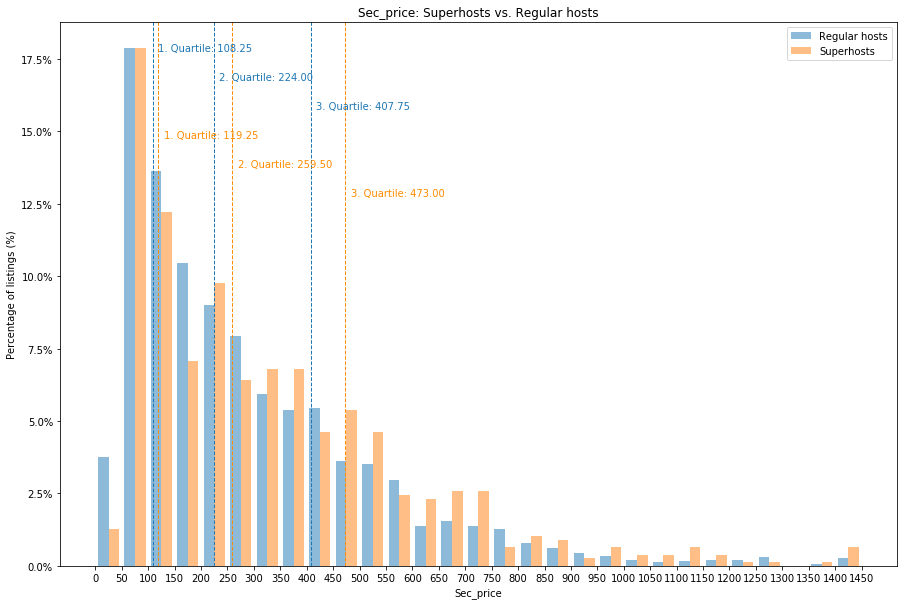

In [335]:
# Total Price + Security Deposit Histogram - bin size = 50 - outliers (top 1% most expensive) are not shown
hist_generator(reg_df, super_df, 'sec_price', 50, max_range_99=True)

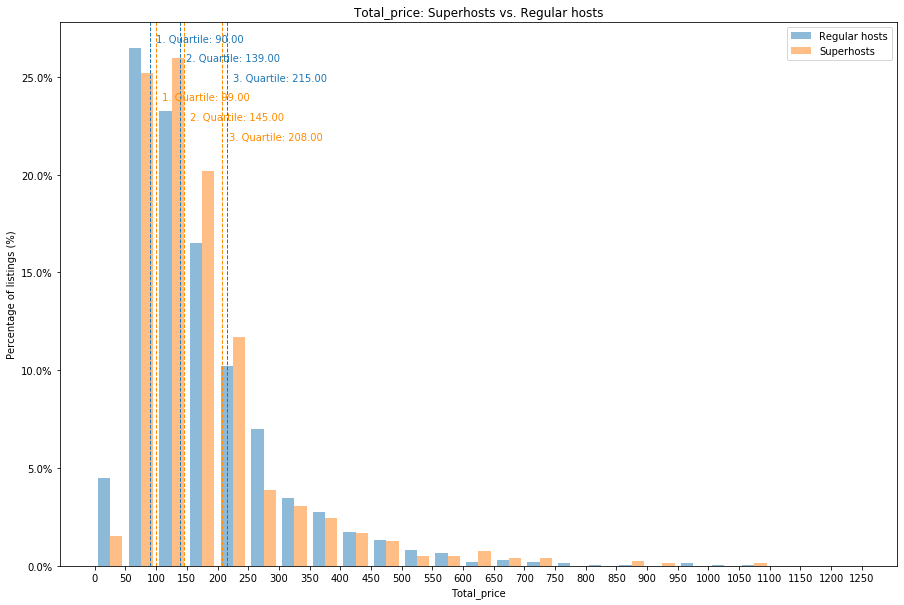

In [336]:
# Total Price Histogram - bin size = 50 
hist_generator(reg_df, super_df, 'total_price', 50)

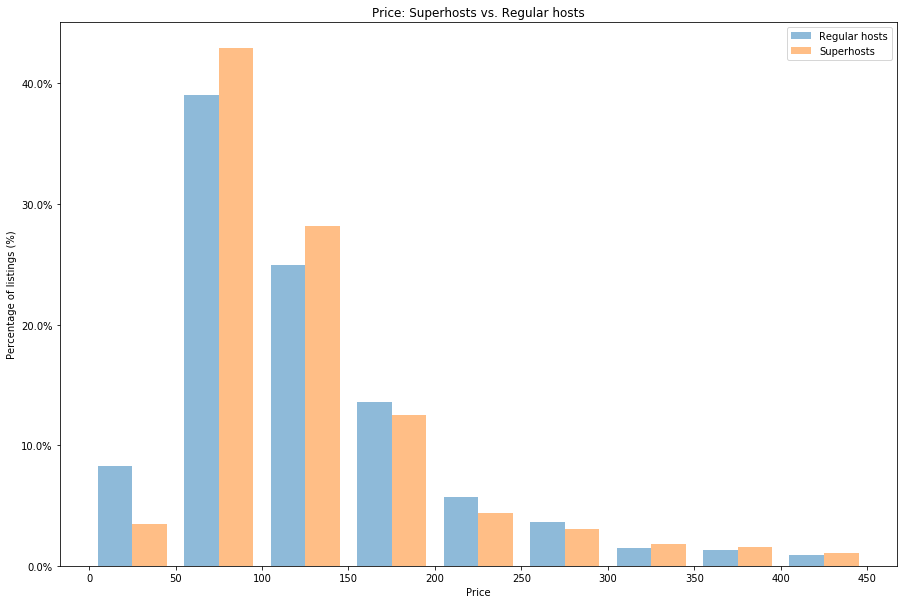

In [337]:
# Price Histogram - bin size = 50, outliers are not plotted (top 1%) 
hist_generator(reg_df, super_df, 'price', 50, percentil = False, max_range_99 = True)

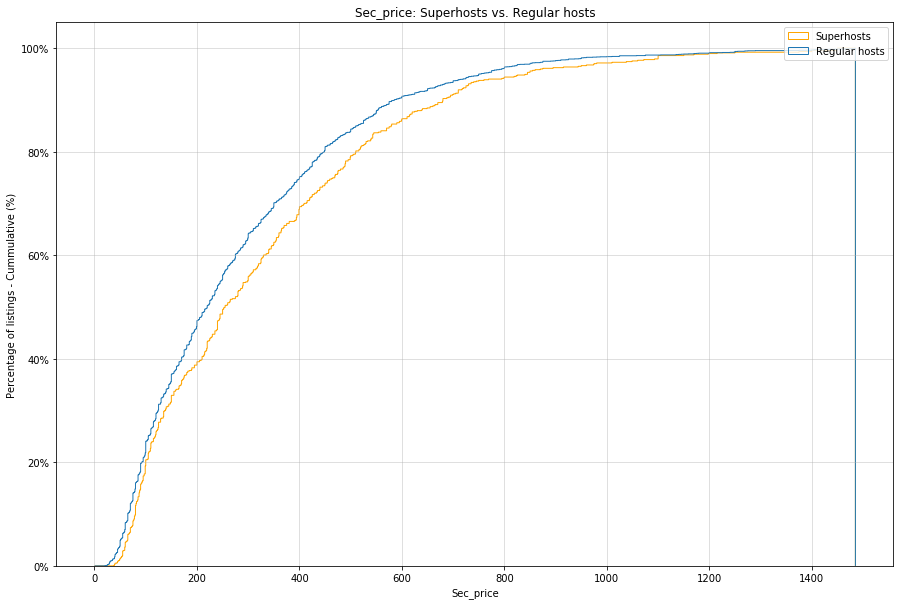

In [200]:
# Total Price + Security Deposit Cummulative Histogram - bin size = 1 - outliers (top 1% most expensive) are not shown
cummulative_hist(reg_df, super_df, 'sec_price', 1, max_range_99=True)

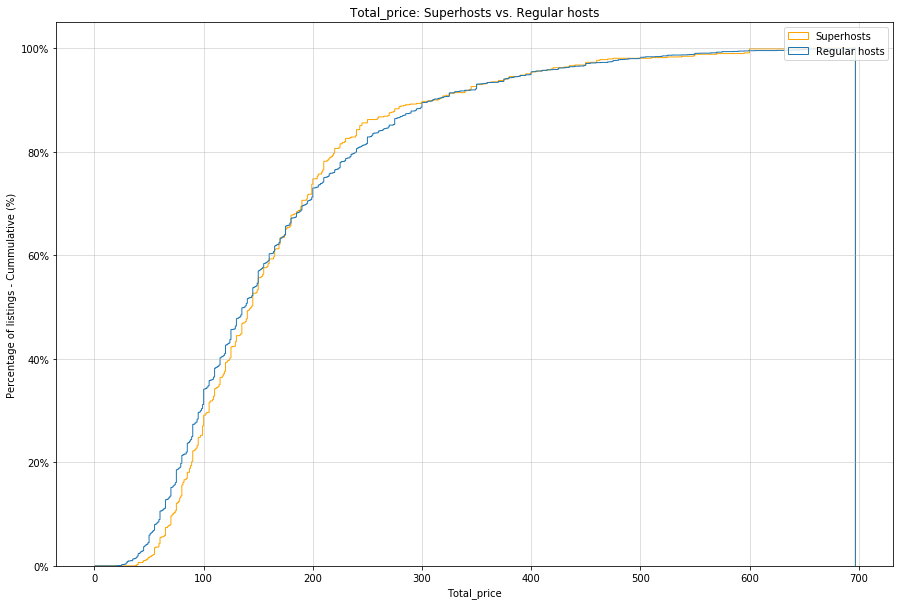

In [36]:
# Total Price Cummulative Histogram - bin size = 1 - outliers (top 1% most expensive) are not shown
cummulative_hist(reg_df, super_df, 'total_price', 1, max_range_99=True)

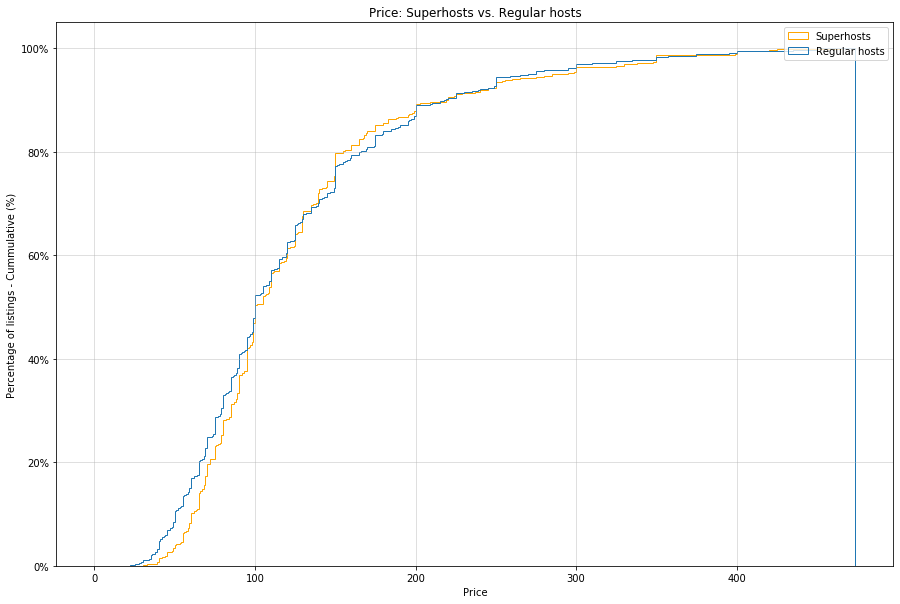

In [325]:
# Price Cummulative Histogram - bin size = 1 - outliers (top 1% most expensive) are not shown
cummulative_hist(reg_df, super_df, 'price', 1, max_range_99=True)

### 1.2. Reviews: are Superhosts in Seattle better reviewed?

#### 1.2.1. Descriptive Statistics and t-tests

   In this Section, I try to understand the meaning behind the review data, and how the mean values differ from superhosts to regular hosts. Statistical tests are used to gauge the mean review differences.

In [220]:
# Superhost Average Review Parameters:
super_rev_mean = pd.DataFrame(super_df[rev_cols].mean())

# Regular host Average Review Parameters:
reg_rev_mean = pd.DataFrame(reg_df[rev_cols].mean())

#### 1.2.2. Deep Dive: Reviews Categories

The previous results are interesting - some review categories are less often reviewed than others, that is, they have more missing values. In this section, I will further investigate the dataset to draw insights on the reviewing process.

In [225]:
# Creating DataFrames with the % of non-missing values in each price column
super_nan = pd.Series(dtype=np.float64)
reg_nan = pd.Series(dtype=np.float64)

for col in rev_cols:
    super_nan = super_nan.append(pd.Series([100*(1 - super_df[col].isnull().mean())], index = [col]))
    reg_nan = reg_nan.append(pd.Series([100*(1 - reg_df[col].isnull().mean())], index = [col]))
    
super_nan = pd.DataFrame(super_nan)
reg_nan = pd.DataFrame(reg_nan)

In [226]:
# Analyzing percentage of non-missing values and the means of the three price components:
comp_df = pd.concat([super_rev_mean, super_nan, reg_rev_mean, reg_nan], axis=1, sort=False)
comp_df.columns = ['Superhosts', '% of Listings S', 'Regular Hosts', '% of Listings R']
comp_df['Delta'] = comp_df['Superhosts'] - comp_df['Regular Hosts']

# Conclusions:
print('{:.1f}% of Superhost Listings are yet to be reviewed'
      .format(100 - super_nan.loc['review_scores_rating', :][0]))
print('{:.1f}% of regular host Listings are yet to be reviewed'
      .format(100 - reg_nan.loc['review_scores_rating', :][0]))
print('One observes that Superhosts receive on average three times as much reviews as their regular counterparts.')
print('Accuracy and Check-In are less often reviewed among regular hosts.')

# Show Results
comp_df.round(1).style.bar(subset=['Delta'], align='mid', color=['#d65f5f', '#5fba7d'])

3.5% of Superhost Listings are yet to be reviewed
20.3% of regular host Listings are yet to be reviewed
One observes that Superhosts receive on average three times as much reviews as their regular counterparts.
Accuracy and Check-In are less often reviewed among regular hosts.


,Superhosts,% of Listings S,Regular Hosts,% of Listings R,Delta
number_of_reviews,41.800000,100.000000,17.200000,100.000000,24.500000
review_scores_rating,97.400000,96.500000,93.700000,79.700000,3.700000
review_scores_accuracy,9.900000,96.500000,9.600000,79.300000,0.400000
review_scores_cleanliness,9.900000,96.500000,9.500000,79.500000,0.400000
review_scores_checkin,10.000000,96.500000,9.700000,79.300000,0.200000
review_scores_communication,10.000000,96.500000,9.800000,79.500000,0.200000
review_scores_location,9.800000,96.500000,9.600000,79.400000,0.200000
review_scores_value,9.700000,96.500000,9.400000,79.400000,0.400000
reviews_per_month,3.000000,96.500000,1.800000,80.300000,1.200000


#### 1.2.3. Statistical tests

The comparison between overall ratings from superhosts and regular hosts can now be performed. I have later found out that Superhosts are chosen based on their overall ratings, so the higher mean rating makes a lot of sense!

In [227]:
# Dropping NaN Values in the weighted rating column:
super_reviews = super_df[rev_cols].dropna(subset=['review_scores_rating'])
reg_reviews = reg_df[rev_cols].dropna(subset=['review_scores_rating'])

In [228]:
# Two-tailed Hypothesis Test: Total Price Results
print('\033[1m' 'Two-tailed Statistical Significance Test (alpha = 0.01):''\033[0m' '\n''\n'
      '\033[1m' 'Null Hypothesis:''\033[0m'
      ' No significant difference between regular hosts average rating and superhosts average rating'  '\n' '\n'
      '\033[1m' 'Alternative Hypothesis:''\033[0m'
      ' There is a significant difference between regular hosts average rating and superhosts average rating' '\n')

# Running the test with alpha = 0.01
t, t_crit = two_tail_t_test(reg_reviews, super_reviews, 'review_scores_rating', 0.01)

# Commenting Results
print('Our t statistic {:.2f} is greater than the t critical value {:.2f}, thus it is in the critical zone.'
      .format(t, t_crit))

print('\n''The result is statistically significant for alpha = 0.01.' '\n''\n'
        '\033[1m''Seattle Superhosts seem to be better reviewed than regular hosts.')

Two-tailed Statistical Significance Test (alpha = 0.01):

Null Hypothesis: No significant difference between regular hosts average rating and superhosts average rating

Alternative Hypothesis: There is a significant difference between regular hosts average rating and superhosts average rating

Our t statistic 13.97 is greater than the t critical value 2.58, thus it is in the critical zone.

The result is statistically significant for alpha = 0.01.

Seattle Superhosts seem to be better reviewed than regular hosts.


#### 1.2.4. Visualizing our Data

Plots help Medium readers to visualize our findings and to understand what story our data tells.

When observing single review categories, the difference between Superhosts and regular hosts ratings is substantial.
Superhosts perform especially better in cleaninless and price/value categories.


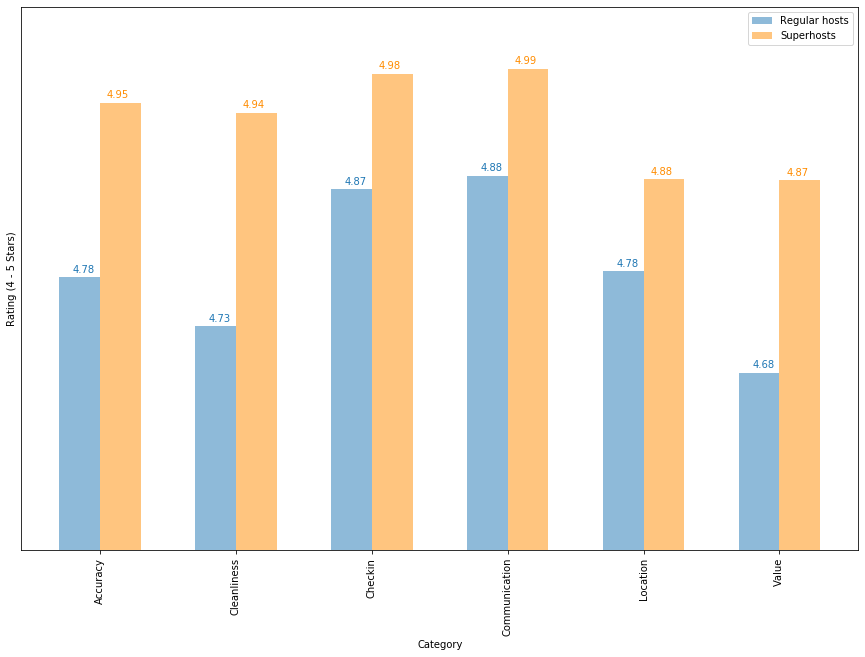

In [343]:
# Bar plots of the mean reviews per category
# Comparison between Regular and Superhosts

# Selecting the relevant rows from comp_df
# We only want the review scores dimensions
# Note that review_scores_rating is a weighted average from the other review scores 

plot_df = comp_df.drop(['number_of_reviews', 'reviews_per_month', 'review_scores_rating'], axis = 0)

# Guests are able to rate hosts from 1 to 5 stars
# Rescale to plot correct ratings
plot_df = plot_df/2

# Cleaning indexes for better looking x-ticks
remove_scores = lambda x: (x.replace('review_scores_', '')).capitalize()
x_names = pd.Series(plot_df.index).apply(remove_scores)

# Creating figures
fig = plt.figure(figsize = (15,10))
ax1 = plt.subplot(1,1,1)

# x_axis and width help to set bar plots next to each other
x_axis = np.arange(len(plot_df.index))
w = 0.3

# Plotting our bar graphs
reg_p = ax1.bar(x_axis, plot_df['Regular Hosts'], width=w, color='C0', alpha=0.5, align='center')
super_p = ax1.bar(x_axis + w, plot_df['Superhosts'], width=w,color='darkorange', alpha=0.5, align='center')

# Adding values over bars
for index, value in enumerate(plot_df['Regular Hosts']):
     plt.text(index-0.05, value*1.001, str(round(value,2)), color = 'C0')
        
for index, value in enumerate(plot_df['Superhosts']):
     plt.text(index+0.2, value*1.001, str(round(value,2)), color = 'darkorange')

# Ticks and Labels
plt.xticks(x_axis + w /2, x_names, rotation='vertical');
plt.yticks([]);
plt.legend([reg_p, super_p],['Regular hosts', 'Superhosts']);
plt.ylabel('Rating (4 - 5 Stars)');
plt.ylim(4.5,5.05);
plt.xlabel('Category');
plt.grid(False)

# Commentary
print('When observing single review categories, the difference between Superhosts'
      ' and regular hosts ratings is substantial.')
print('Superhosts perform especially better in cleaninless and price/value categories.')

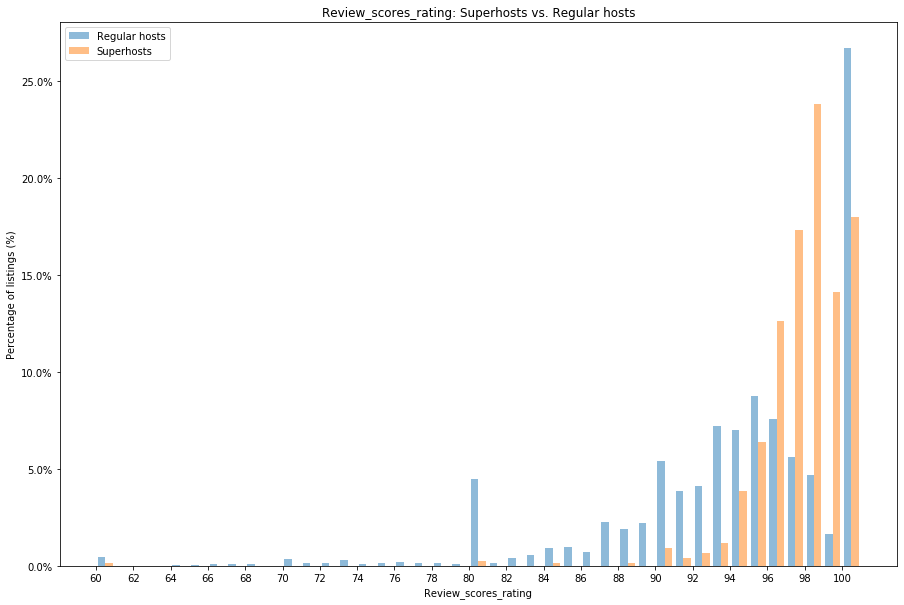

In [232]:
# Histogram of ratings
# The smallest value on the x-axis is obtained 
# via the smallest 1% percentile between regular and superhosts
worst_review = min(super_reviews['review_scores_rating'].quantile(0.01), reg_reviews['review_scores_rating'].quantile(0.01))
hist_generator(reg_reviews, super_reviews, 'review_scores_rating', 1, percentil=False, xmin=int(worst_review/10)*10)

In [341]:
# Investigating the 100% Reviews from regular hosts
# They have roughly 4 reviews on average!
reg_reviews[reg_reviews['review_scores_rating']==100]['number_of_reviews'].mean()

3.9458204334365323

In [342]:
# Comparison with Superhosts
super_reviews[super_reviews['review_scores_rating']==100]['number_of_reviews'].mean()

17.40740740740741

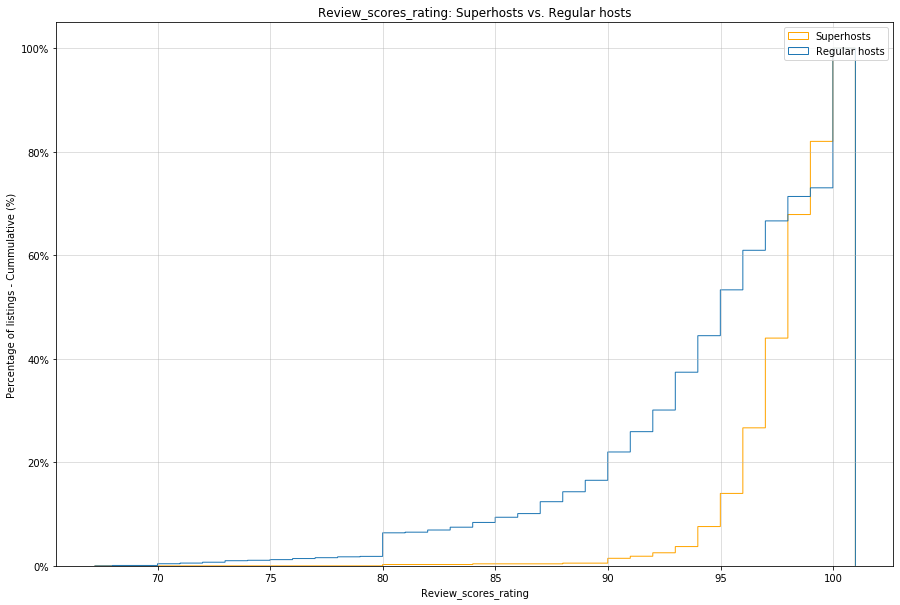

In [233]:
# Cummulative histogram of ratings
cummulative_hist(reg_reviews, super_reviews, 'review_scores_rating', 0.01, xmin = worst_review)

## 2. The Relationship between Price and Location

As a rule of thumb, we expect prices to be correlated with location - the better the location, the higher the price. I am interested in finding out if this is actually true. I will also compare the AirBnB data with the current real state prices in the neighborhoods, and find out if there is any correlation between these values. 

Based on the Seattle AirBnB data, I would like to know - do the most expensive neighborhoods in Seattle have the most expensive Airbnb listings? Let's find out!

In [46]:
# Creating data frame with neighbourhood cleansed name, price and total price (price + cleaning) of listing
# as well as location data
price_loc_df = listing_df[['neighbourhood_cleansed', 'latitude', 'longitude', 'price', 'total_price']]

# Finding the mean price & total price per neighbourhood
# Sorting df per price, descending
price_rank = (price_loc_df.groupby('neighbourhood_cleansed').mean()
                .sort_values(by='price', ascending=False))

# Finding the number of listings per neighbourhood
number_lists = ((price_loc_df.groupby('neighbourhood_cleansed').count()
                    .rename(columns={'price':'airbnb_count'})['airbnb_count']))

# Concatenating both dataframes
rank_neig = pd.concat([price_rank, number_lists], axis=1, sort=False)

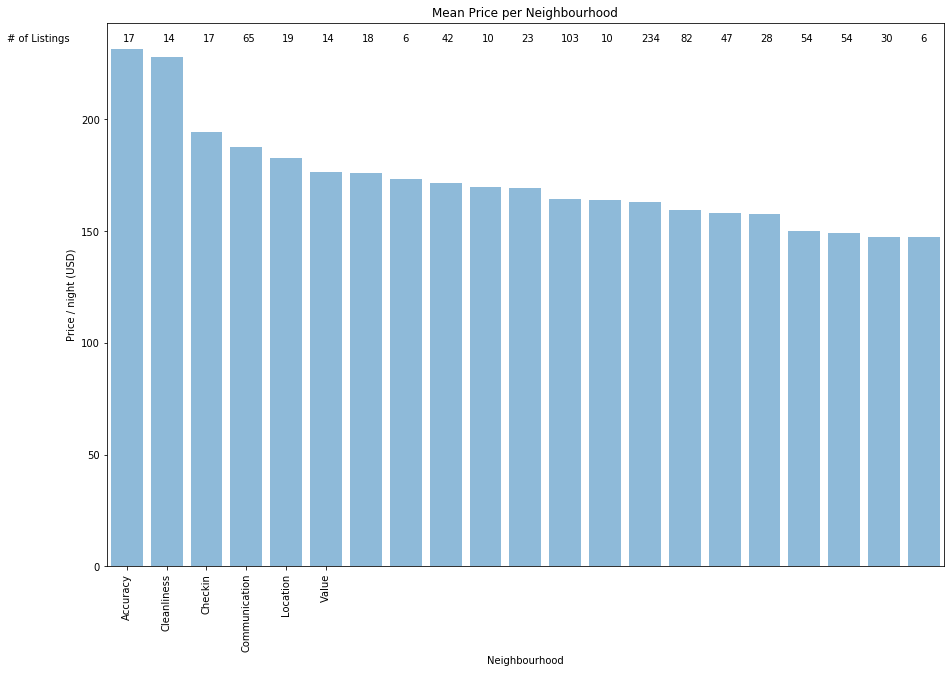

In [47]:
# Plotting mean prices and number of listings per Neighbourhood
# 20 Most Expensive Neighbourhoods

# Creating figures
fig = plt.figure(figsize = (15,10))
ax1 = plt.subplot(1,1,1)

# Plotting our bar graphs
price = ax1.bar(rank_neig.index, rank_neig['price'], color='C0', alpha=0.5, align='center')
        
# Ticks and Labels
plt.xticks(x_axis, x_names, rotation='vertical');
plt.xlim(-0.5,20.5);
plt.ylabel('Price / night (USD)');
plt.xlabel('Neighbourhood');
plt.title('Mean Price per Neighbourhood')

# Adding number of listings
plt.text(-3, 235, '# of Listings')

for index, value in enumerate(rank_neig['price']):
    if index <= 20:
        plt.text(index-0.1, 235, str(rank_neig['airbnb_count'][index]))
    else:
        break

In [48]:
# The bar plot is not a perfect visualization
# In order to improve it, let's try a bubble plot map!

# Bubble Colors will represent the mean price of the listings
c = rank_neig['price']

# Bubble Size will represent the number of listings
s = rank_neig['airbnb_count']

# Scatter plot with longitude (y) and latitude (x)
line_plot_fig, line_plot_ax = plt.subplots(figsize=(15,10))
graph = line_plot_ax.scatter(rank_neig['longitude'], rank_neig['latitude'], c=c, cmap = 'RdPu', s = s*10);

# Generate html-file with the map 
mplleaflet.show(fig=line_plot_fig, tiles='cartodb_positron', path='seattle_airbnb_map.html')

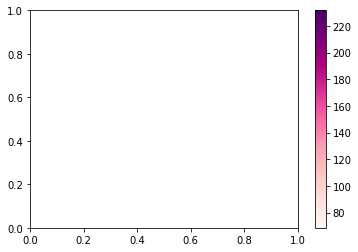

In [49]:
# Color bar has to be ploted separately
# otherwise there are issues with the map
plt.colorbar(graph);

In [50]:
# Inspiration: https://towardsdatascience.com/loading-data-from-openstreetmap-with-python-and-the-overpass-api-513882a27fd0
# Let's use the Open Street Maps Data to find amenities in Seattle
# The goal is to visualize AirBnB offerings over the city's busiest areas
# Here we searched for tourism attractions, galleries, artwork and museums
# As well as bars, pubs and restaurants

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area(3600237385);
(node["tourism"~"attraction|gallery|artwork|museum"](area);
 way["tourism"~"attraction|gallery|artwork|museum"](area);
 rel["tourism"~"attraction|gallery|artwork|museum"](area);
);
area(3600237385);
(node["amenity"~"bar|pub|restaurant"](area);
 way["amenity"~"bar|pub|restaurant"](area);
 rel["amenity"~"bar|pub|restaurant"](area);
);
out center;
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()

In [51]:
# Collect coordinates into list
coords = []
for element in data['elements']:
    if element['type'] == 'node':
        lon = element['lon']
        lat = element['lat']
        coords.append((lon, lat))

# Convert coordinates into numpy array
X_coor = np.array(coords)

# We want to plot the number of attractions per neighbourhood
# To identify in which neighbourhodod the node is located, I will use the knn approach
n_neighbors = 5

# Our AirBnB Listings work as my training set
location = price_loc_df[['longitude','latitude']].to_numpy()
neighbourhood = price_loc_df['neighbourhood_cleansed'].to_numpy()

# We create an instance of Neighbours Classifier and fit the data
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
clf.fit(location, neighbourhood)

# Predicting the neighbourhood of the amenities
am_neig = pd.DataFrame(clf.predict(X_coor)).rename(columns={0:'neighbourhood'})

# Appending the number of amenities per neighbourhood to the original df
rank_neig['amenities_count'] =  am_neig['neighbourhood'].value_counts()

# Neighbourhoods with no listed amenities - fill NaN values
rank_neig['amenities_count'] = rank_neig['amenities_count'].fillna(0)

In [52]:
# Bubble Colors will represent the mean price of the listings
c = rank_neig['price']

# Bubble Size will represent the number of Airbnb listings
s = rank_neig['airbnb_count']

# Bubble Size will represent the number of amenities
s_am =  rank_neig['amenities_count']

# Scatter plot with longitude (y) and latitude (x)
line_plot_fig, line_plot_ax = plt.subplots(figsize=(15,10))
graph = line_plot_ax.scatter(rank_neig['longitude'], rank_neig['latitude'], c=c, cmap = 'RdPu', s = s*10);
line_plot_ax.scatter(rank_neig['longitude'], rank_neig['latitude'], c='grey', alpha = 0.1, s = s_am*100);

# Generate html-file with the map 
mplleaflet.show(fig=line_plot_fig, tiles='cartodb_positron', path='seattle_amenities_map.html')

In [53]:
# Dataset - Average rent price in Seattle
# https://www.rentcafe.com/average-rent-market-trends/us/wa/seattle/
# Adapted to match neighbourhood names from the Kaggle dataset
rent_df = (pd.read_csv('./seattle_rent.csv')).set_index('neighbourhood')

# Concatenating the airbnb data set and the rent data
neigh_data = pd.concat([rank_neig, rent_df], axis=1, sort=False)

# Dropping neighbourhoods with no airbnb data
neigh_data = neigh_data.dropna(subset=['price'])

Pearsons correlation: 0.494
Spearmans correlation: 0.600


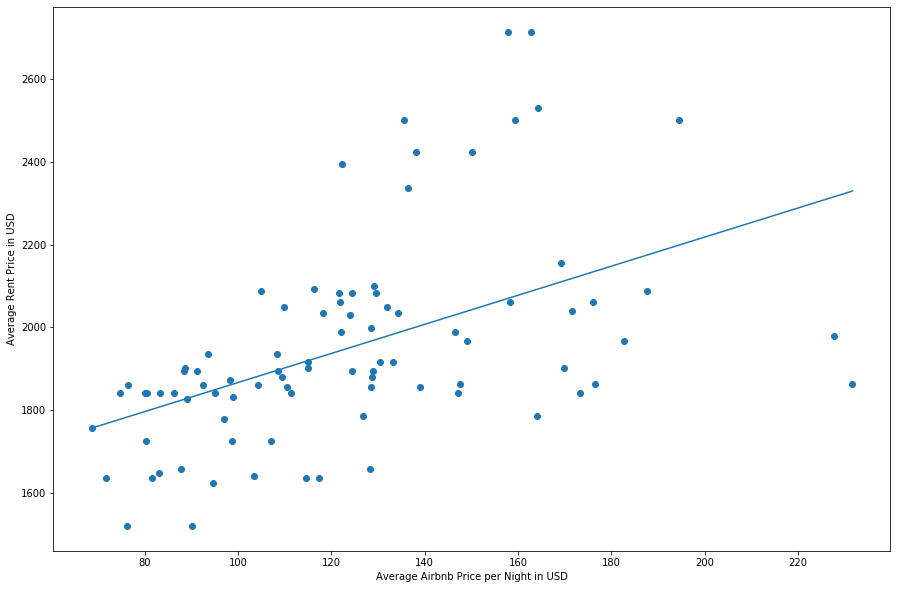

In [54]:
# We will investigate the correlation between Airbnb prices
# and rent prices in Seattle
plt.figure(figsize = (15,10))    
plt.scatter(neigh_data['price'], neigh_data['rent_price']);
plt.ylabel('Average Rent Price in USD')
plt.xlabel('Average Airbnb Price per Night in USD')

# Find the slope and intercept of the best fit line (least squares)
slope, intercept = np.polyfit(neigh_data['price'], neigh_data['rent_price'], 1)

# Create a list of values in the best fit line
abline_values = [slope * i + intercept for i in neigh_data['price']]

# Plot the best fit line over the actual values
plt.plot(neigh_data['price'], abline_values)

# calculate Pearson's correlation (more sensitive to outliers)
corr, _ = stats.pearsonr(neigh_data['price'], neigh_data['rent_price'])
print('Pearsons correlation: %.3f' % corr)

# This indicates a medium association between Airbnb and rent prices.
# https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide.php

# Calculate spearman's correlation
corr, _ = stats.spearmanr(neigh_data['price'], neigh_data['rent_price'])
print('Spearmans correlation: %.3f' % corr)

# This indicates a strong positive relationship between the ranks of Airbnb and Rent Prices. 
# That is, the higher a neighbourhood ranked in Airbnb Prices, the higher it ranked in Rent Prices also, and vice versa.

## 3. How do availability and price fluctuate through the year?

As a rule of thumb, we expect prices to increase with demand - for instance, higher prices on weekends - and to decrease, if the number of available properties is bigger than the demand. Let's dive into the Seattle and Boston datasets to find out if this phenomenon is actually observable. 

In [57]:
# Analyzing when do these price and offer peaks happen: weekends?

# Weekday Class Attribute (Monday is 0, Sunday is 6)
# Weekend = (5,6)
ret_weekday = lambda x: x.weekday()
calendar_df['weekday'] = calendar_df['date'].apply(ret_weekday)
calendar_df_b['weekday'] = calendar_df_b['date'].apply(ret_weekday)

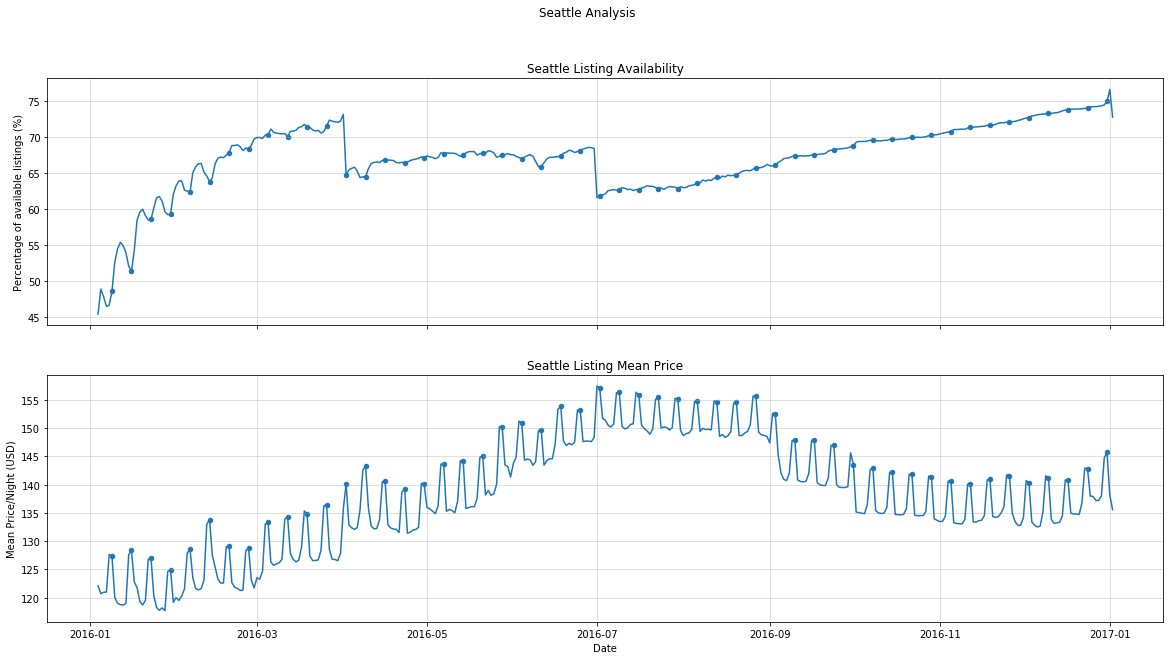

In [58]:
# Plotting and Visualizing data - Seattle

# We calculate the mean price and availability per date
time_df = calendar_df.groupby('date').mean().reset_index()

# Weekends - Saturdays
week_df = time_df[(time_df['weekday'] == 5)]

# Stacked subplots with same x axis (date)
fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (20,10));
fig.suptitle('Seattle Analysis');

# Adjusting Availability Plot
ax1.plot(time_df['date'], time_df['available']*100);
ax1.scatter(week_df['date'], week_df['available']*100, s = 20);
ax1.set_title('Seattle Listing Availability');
ax1.set_ylabel('Percentage of available listings (%)');
ax1.grid(alpha = 0.5);

# Adjusting Price Plot
ax2.plot(time_df['date'], time_df['price']);
ax2.scatter(week_df['date'], week_df['price'], s= 20);
ax2.set_title('Seattle Listing Mean Price');
ax2.set_ylabel('Mean Price/Night (USD)');
ax2.set_xlabel('Date');
ax2.grid(alpha = 0.5)

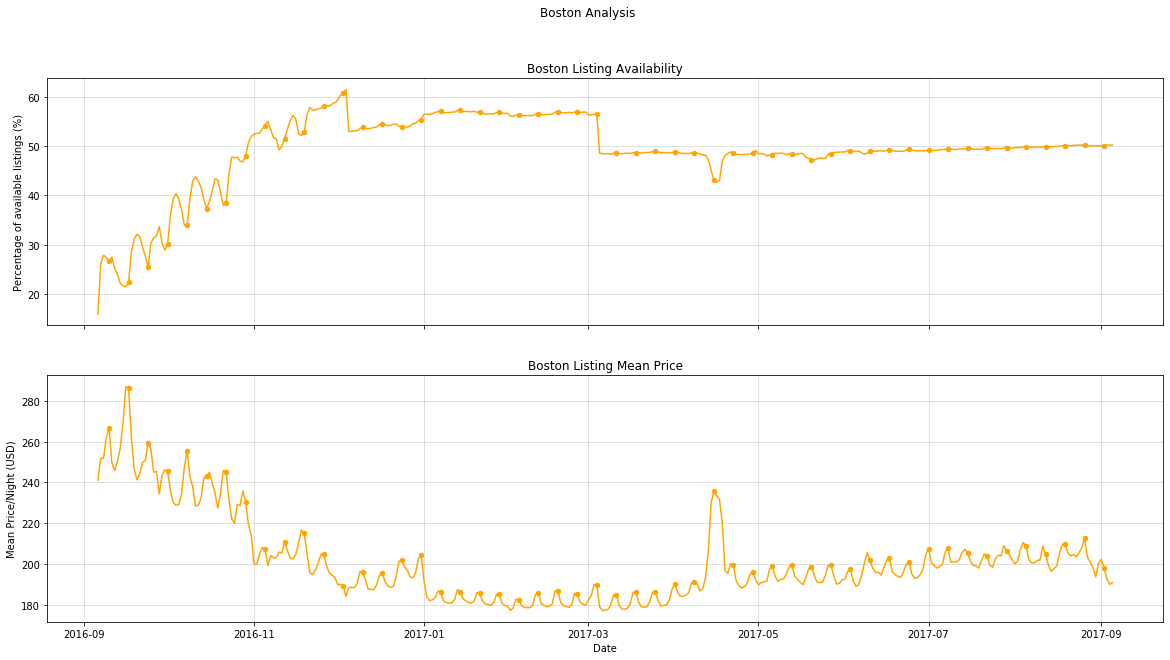

In [59]:
# Plotting and Visualizing data - Boston

# We calculate the mean price and availability per date
time_df_b = calendar_df_b.groupby('date').mean().reset_index()

# Weekends - Saturdays
week_df_b = time_df_b[(time_df_b['weekday'] == 5)]

# Stacked subplots with same x axis (date)
fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (20,10));
fig.suptitle('Boston Analysis');

# Adjusting Availability Plot
ax1.plot(time_df_b['date'], time_df_b['available']*100, c= 'darkorange');
ax1.scatter(week_df_b['date'], week_df_b['available']*100, s = 20, c= 'darkorange');
ax1.set_title('Boston Listing Availability');
ax1.set_ylabel('Percentage of available listings (%)');
ax1.grid(alpha = 0.5);

# Adjusting Price Plot
ax2.plot(time_df_b['date'], time_df_b['price'], c = 'darkorange');
ax2.scatter(week_df_b['date'], week_df_b['price'], s = 20, c= 'darkorange')
ax2.set_title('Boston Listing Mean Price');
ax2.set_ylabel('Mean Price/Night (USD)');
ax2.set_xlabel('Date');
ax2.grid(alpha = 0.5)

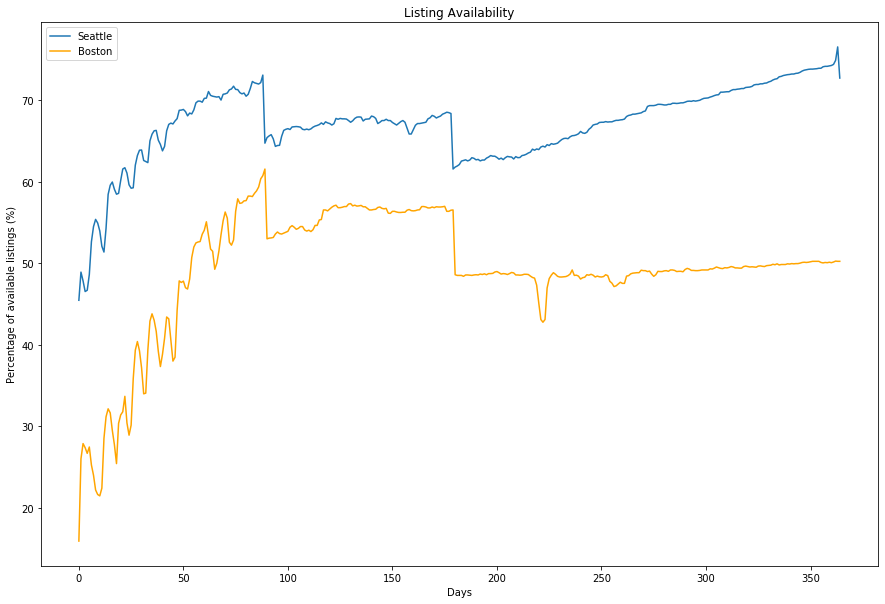

In [60]:
# Creating a new column on each dataframe
# to plot time intervals instead of dates
calendar_df['interval'] = calendar_df['date'] - calendar_df['date'].min()
calendar_df_b['interval'] = calendar_df_b['date'] - calendar_df_b['date'].min()

# Transforming datetime objects into ints
return_days = lambda x: x.days
calendar_df['interval'] = calendar_df['interval'].apply(return_days)
calendar_df_b['interval'] = calendar_df_b['interval'].apply(return_days)

# Grouping listing by interval and calculating
# mean availability
time_df = calendar_df.groupby('interval').mean().reset_index()
time_df_b = calendar_df_b.groupby('interval').mean().reset_index()

plt.figure(figsize=(15,10))
plt.plot(time_df['interval'], time_df['available']*100, c = 'C0', label = 'Seattle');
plt.plot(time_df_b['interval'], time_df_b['available']*100, c = 'darkorange', label = 'Boston');
plt.title('Listing Availability');
plt.ylabel('Percentage of available listings (%)');
plt.xlabel('Days');
plt.legend();

## 4. Predicting Price through Property Characteristics

My last goal is to understand how do property characteristics (e.g. size, room type) influence price. I will try to construct a model to predict price using just those features, and then interpret it.

### 4.1. Feature Selection

Beforehand we've unterstood and cleaned the data, but we will review this step focusing on a price prediction model. Our goal is to identify which features influence price the most.

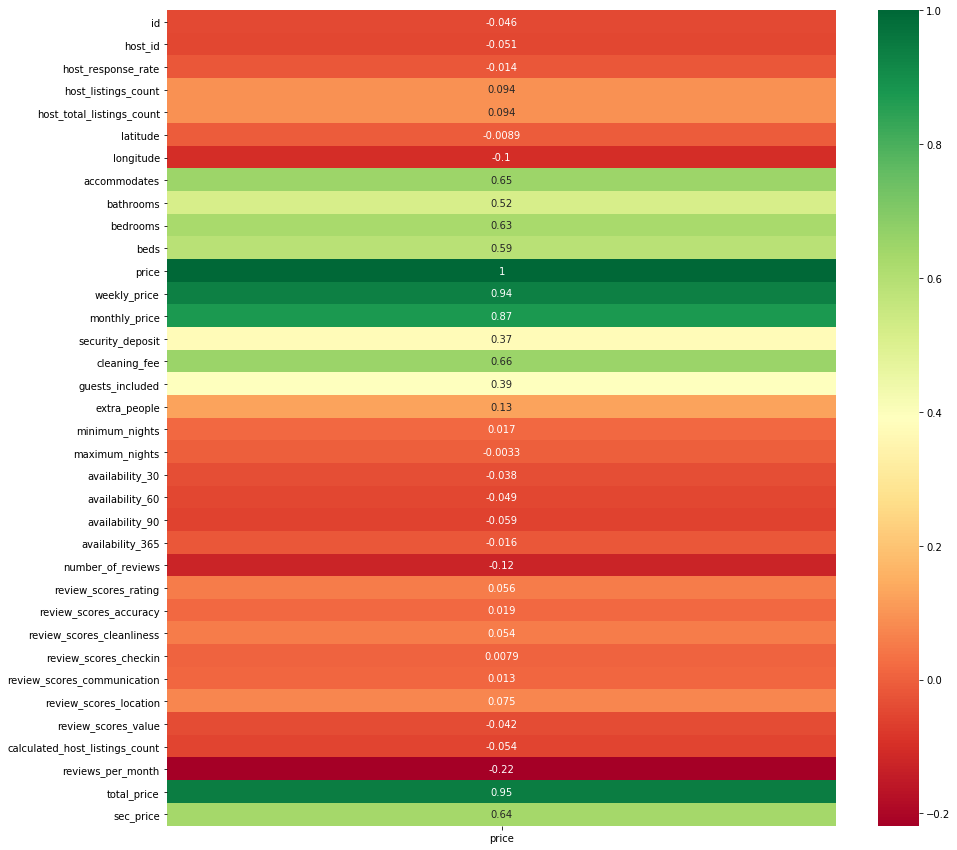

In [234]:
# Visualizing feature correlation
# Price has the strongest correlation with room characteristics
# and other price parameters, which are actually derived from the price (e.g. monthly price)
plt.figure(figsize=(15,15))
sns.heatmap(pd.DataFrame(listing_df.corr()['price']), annot = True, cmap="RdYlGn");

In [236]:
# The Heatmap gives a first insight on relevant features to predict price:
features = ['price', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'extra_people']

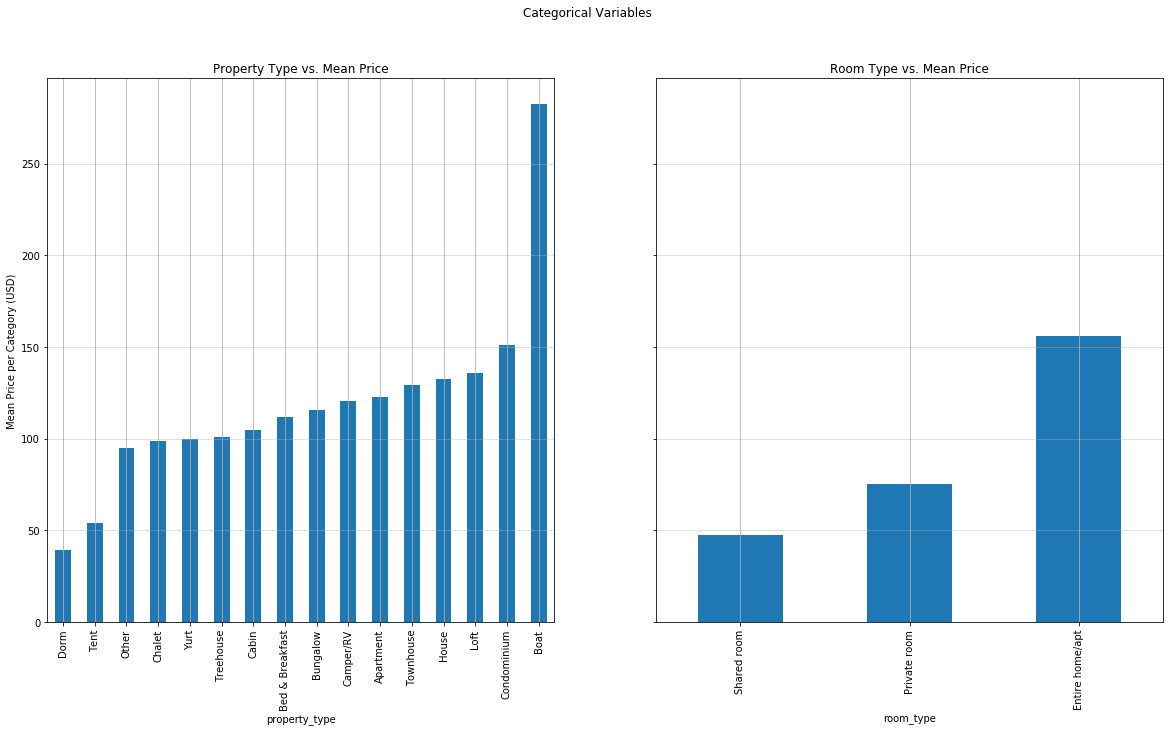

In [237]:
# Now let's take a look into categorical data
# Visualizing property_type/room_type and mean price relation

# Subplots side by side, sharing y axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (20,10));
fig.suptitle('Categorical Variables');

# Adjusting Availability Plot
listing_df.groupby('property_type').mean()['price'].sort_values().plot(kind='bar', ax=ax1);
ax1.set_title('Property Type vs. Mean Price');
ax1.set_ylabel('Mean Price per Category (USD)');
ax1.grid(alpha = 0.5, axis = 'y');

# Adjusting Price Plot
listing_df.groupby('room_type').mean()['price'].sort_values().plot(kind='bar', ax=ax2);
ax2.set_title('Room Type vs. Mean Price');
ax2.grid(alpha = 0.5, axis = 'y');

In [238]:
# We observe a relationship between price and those categorical values
# The 'amenities' column still has to be interpreted - data is too messy!

features = features + ['property_type', 'room_type', 'amenities']

### 4.2. Data Preparation

Now it's time to clean and prepare our data. In the previous step, we've selected some numerical features, and investigated the categorical data. Let's create an appropriate dataframe for our model.

Our feature selection follows the Correlation Matrix method described here: https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

In [239]:
# Creating our Input DataFrame
# It includes the variable to predict, 'price'
model_input = listing_df[features]

In [241]:
# For our ML Model, we have to delete rows with NaN values
model_input = model_input.dropna()

In [242]:
# Creating dummy variables for our categorical data 
model_input = pd.get_dummies(model_input, columns = ['property_type','room_type'])

# As we've seen before, 'amenities' has rather messy data
# We'll use the number of amenities as our variable
count_comma = lambda x: len(x.split(","))
model_input['amenities_count'] = model_input['amenities'].apply(count_comma)
model_input = model_input.drop(columns=['amenities'])

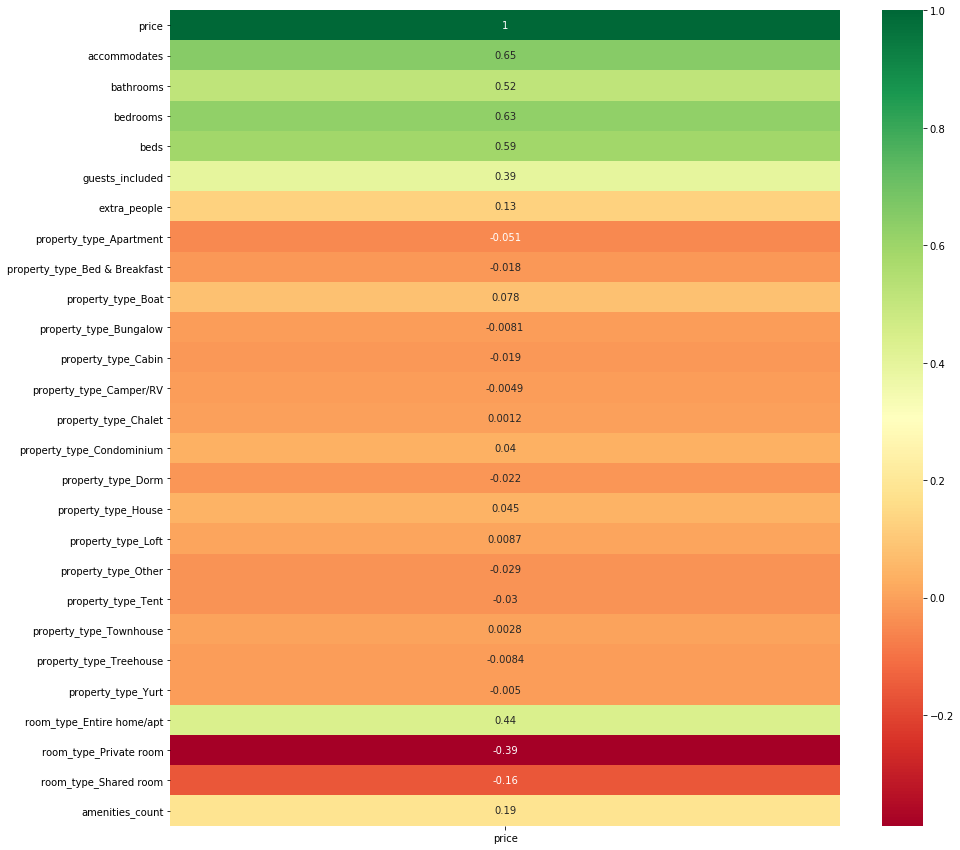

In [243]:
# Reviewing our heatmap, we observe that the property_type columns
# are not so helpful as previously thought.
plt.figure(figsize=(15,15))
sns.heatmap(pd.DataFrame(model_input.corr()['price']), annot = True, cmap="RdYlGn");

In [244]:
# We'll drop them from our model input

# Finding columns with property_type in name
drop_col = [x for x in model_input.columns if x.find('property_type') != -1]

# Dropping from model_input
model_input = model_input.drop(columns=drop_col)

### 4.3. Modeling

In order to gather insight on how much the price variation is explained by the selected room characteristics, I will use a Linear Regression model and its coefficient of determination. 

In [290]:
# Separating our features and target
X = model_input.drop(columns = ['price'])
y = model_input['price']

# Creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4, random_state = 10)

# Instantiate the model
lm_model = LinearRegression(normalize=True)

# Fit the model
lm_model.fit(X_train, y_train)

# Predict with test set
lm_test = lm_model.predict(X_test)

# Predict with train set
lm_train = lm_model.predict(X_train)

# Score the model
r2_score_test = r2_score(y_test,lm_test)
r2_score_train = r2_score(y_train, lm_train)

# Looking at the coeficients
pd.DataFrame({'variable': X.columns, 'estimate': lm_model.coef_})

,variable,estimate
0,accommodates,9.356973
1,bathrooms,34.775165
2,bedrooms,26.748002
3,beds,0.217198
4,guests_included,1.189899
5,extra_people,0.082861
6,room_type_Entire home/apt,24.669659
7,room_type_Private room,-19.957922
8,room_type_Shared room,-41.697672
9,amenities_count,0.118831


In [307]:
# The scores hint at a underfitted model
# We would need more features to create a better predictor

print('Coefficient of Determination (Test): {:.3f}'.format(r2_score_test))
print('Coefficient of Determination (Train): {:.3f}'.format(r2_score_train))

Coefficient of Determination (Test): 0.533
Coefficient of Determination (Train): 0.526
